In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from google.colab import drive
drive.mount('/content/drive')
S = np.load('/content/drive/My Drive/Toric Code 2D/3: FRRBM on 3x3/Data/S20_30.npy')
SS = np.array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1, +1, -1, -1, -1, -1, -1, +1, -1, -1, -1, -1, -1, +1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1, +1, +1, +1, -1, -1, -1, -1, -1, -1],
               [-1, +1, -1, -1, -1, -1, -1, +1, -1, +1, +1, +1, -1, +1, -1, -1, -1, -1]])

# Translational symmetry, Real variables.
(ss, tt, N) = (0.01, 100, len(S))
BF = torch.tensor([0.0])
WF = torch.tensor([np.pi/4, np.pi/4, np.pi/4, np.pi/4])
BV = torch.tensor([0.1], requires_grad=True)
WV = torch.tensor([1.4, 1.5, 1.6, 1.7], requires_grad=True)
optimizer = torch.optim.Adam([BV, WV], lr=ss)

Mounted at /content/drive


In [ ]:
# pr is the shortcut for cosh function.
def pr(b, w, s1, s2, s3, s4):
    result = torch.cosh(b[0] + 1j * (w[0] * s1 + w[1] * s2 + w[2] * s3 + w[3] * s4))
    return result

# ph is the phase function.
def ph(bv, wv, bf, wf, s):
    result = (pr(bv, wv, s[0], s[3], s[2], s[15]) * pr(bv, wv, s[1], s[4], s[0], s[16])
              * pr(bv, wv, s[2], s[5], s[1], s[17]) * pr(bv, wv, s[6], s[9], s[8], s[3])
              * pr(bv, wv, s[7], s[10], s[6], s[4]) * pr(bv, wv, s[8], s[11], s[7], s[5])
              * pr(bv, wv, s[12], s[15], s[14], s[9]) * pr(bv, wv, s[13], s[16], s[12], s[10])
              * pr(bv, wv, s[14], s[17], s[13], s[11]) * pr(bf, wf, s[4], s[6], s[3], s[0])
              * pr(bf, wf, s[5], s[7], s[4], s[1]) * pr(bf, wf, s[3], s[8], s[5], s[2])
              * pr(bf, wf, s[10], s[12], s[9], s[6]) * pr(bf, wf, s[11], s[13], s[10], s[7])
              * pr(bf, wf, s[9], s[14], s[11], s[8]) * pr(bf, wf, s[16], s[0], s[15], s[12])
              * pr(bf, wf, s[17], s[1], s[16], s[13]) * pr(bf, wf, s[15], s[2], s[17], s[14]))
    return result

# nor is the normalize function.
def nor(bv, wv, bf, wf):
    result = 0
    for i in range(len(S)):
      result += abs(ph(bv, wv, bf, wf, S[i]))
    return result


# The 9 vertex operators flip qubits.
A1 = np.diag([-1, +1, -1, -1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, +1])
A2 = np.diag([-1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1])
A3 = np.diag([+1, -1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1])
A4 = np.diag([+1, +1, +1, -1, +1, +1, -1, +1, -1, -1, +1, +1, +1, +1, +1, +1, +1, +1])
A5 = np.diag([+1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1, +1])
A6 = np.diag([+1, +1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1])
A7 = np.diag([+1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, +1, -1, +1, -1, -1, +1, +1])
A8 = np.diag([+1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1, +1])
A9 = np.diag([+1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1])
S1 = np.dot(S, A1)
S2 = np.dot(S, A2)
S3 = np.dot(S, A3)
S4 = np.dot(S, A4)
S5 = np.dot(S, A5)
S6 = np.dot(S, A6)
S7 = np.dot(S, A7)
S8 = np.dot(S, A8)
S9 = np.dot(S, A9)

# lam is the multiplier to amplify the choice of ground state
def criterion(bv, wv, bf, wf):
    V = torch.empty((9*N,), dtype=torch.complex64)
    for k in range(N):
        sub = ph(bv, wv, bf, wf, S[k])
        V[k] = ph(bv, wv, bf, wf, S1[k]) - sub
        V[N+k] = ph(bv, wv, bf, wf, S2[k]) - sub
        V[2*N+k] = ph(bv, wv, bf, wf, S3[k]) - sub
        V[3*N+k] = ph(bv, wv, bf, wf, S4[k]) - sub
        V[4*N+k] = ph(bv, wv, bf, wf, S5[k]) - sub
        V[5*N+k] = ph(bv, wv, bf, wf, S6[k]) - sub
        V[6*N+k] = ph(bv, wv, bf, wf, S7[k]) - sub
        V[7*N+k] = ph(bv, wv, bf, wf, S8[k]) - sub
        V[8*N+k] = ph(bv, wv, bf, wf, S9[k]) - sub
    v = torch.norm(V)/nor(bv, wv, bf, wf)
    return v

In [ ]:
# Stochastic gradient descent
start_time = time.time()
COST = []
ABV = []
AWV = [[], [], [], []]
for h in range(tt):
    cost = criterion(BV, WV, BF, WF)
    COST.append(cost.tolist())
    ABV.append(BV[0].tolist())
    for p in range(4):
        AWV[p].append(WV[p].tolist())
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 287.35967898368835 seconds


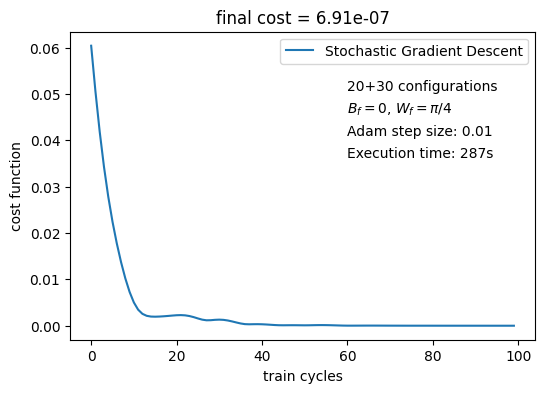

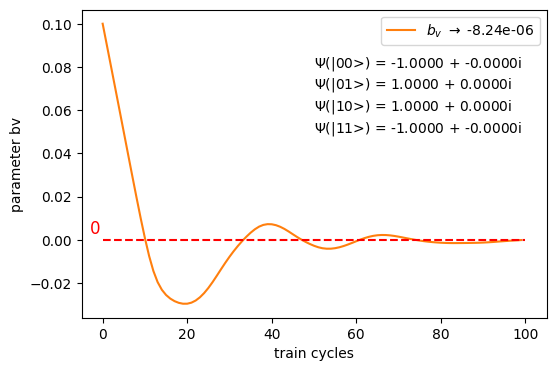

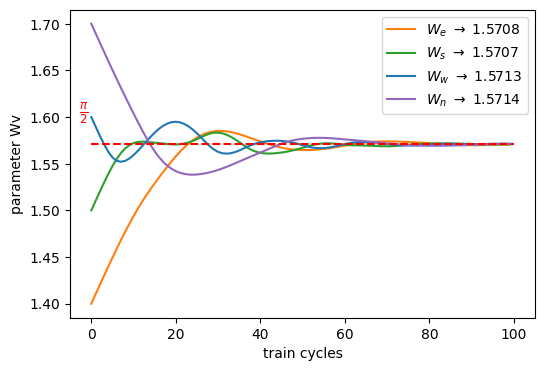

In [ ]:
# Visualize results: Cost
Final = cost.data.item()
fig1 = plt.figure(figsize=(6, 4))
plt.plot(COST, label="Stochastic Gradient Descent")
plt.title("final cost = %.2e" % Final)
plt.text(0.6 * tt, 0.84 * COST[0], "20+30 configurations")
plt.text(0.6 * tt, 0.76 * COST[0], "$B_{f} = 0$, $W_{f} = \pi/4$")
plt.text(0.6 * tt, 0.68 * COST[0], "Adam step size: %.2f" % ss)
plt.text(0.6 * tt, 0.6 * COST[0], "Execution time: %is" % execution_time)
plt.xlabel("train cycles")
plt.ylabel("cost function")
plt.legend()
plt.show()

# Visualize results: BV
fig2 = plt.figure(figsize=(6, 4))
plt.plot(ABV, color='tab:orange', label=r"$b_v$ $\rightarrow$ %.2e" % BV[0].data.item())
plt.plot([0, tt], [0.0, 0.0], 'r--', linewidth=1.5)
plt.text(-0.03 * tt, 0.003, '0', color='r', fontsize=12)
plt.text(0.5 * tt, 0.8 * ABV[0], "$\Psi$(|00>) = %.4f + %.4fi" % (
    ph(BV, WV, BF, WF, SS[0]).data.item().real, ph(BV, WV, BF, WF, SS[0]).data.item().imag))
plt.text(0.5 * tt, 0.7 * ABV[0], "$\Psi$(|01>) = %.4f + %.4fi" % (
    ph(BV, WV, BF, WF, SS[1]).data.item().real, ph(BV, WV, BF, WF, SS[1]).data.item().imag))
plt.text(0.5 * tt, 0.6 * ABV[0], "$\Psi$(|10>) = %.4f + %.4fi" % (
    ph(BV, WV, BF, WF, SS[2]).data.item().real, ph(BV, WV, BF, WF, SS[2]).data.item().imag))
plt.text(0.5 * tt, 0.5 * ABV[0], "$\Psi$(|11>) = %.4f + %.4fi" % (
    ph(BV, WV, BF, WF, SS[3]).data.item().real, ph(BV, WV, BF, WF, SS[3]).data.item().imag))
plt.xlabel("train cycles")
plt.ylabel("parameter bv")
plt.legend()
plt.show()

# Visualize results: WV
fig3 = plt.figure(figsize=(6, 4))
plt.plot(AWV[0], color='tab:orange', label=r"$W_e$ $\rightarrow$ %.4f" % WV[0].data.item())
plt.plot(AWV[1], color='tab:green', label=r"$W_s$ $\rightarrow$ %.4f" % WV[1].data.item())
plt.plot(AWV[2], color='tab:blue', label=r"$W_w$ $\rightarrow$ %.4f" % WV[2].data.item())
plt.plot(AWV[3], color='tab:purple', label=r"$W_n$ $\rightarrow$ %.4f" % WV[3].data.item())
plt.plot([0, tt], [1.5708, 1.5708], 'r--', linewidth=1.5)
plt.text(-0.03 * tt, 1.6, r'$\frac{\pi}{2}$', color='r', fontsize=12)
plt.xlabel("train cycles")
plt.ylabel("parameter Wv")
plt.legend()
plt.show()

In [ ]:
# Repeat for different initials
(ss, tt, N) = (0.01, 100, len(S))
BF = torch.tensor([0.0])
WF = torch.tensor([np.pi/4, np.pi/4, np.pi/4, np.pi/4])
BV = torch.tensor([0.1], requires_grad=True)
WV = torch.tensor([-0.1, 0.1, 1.5, 1.7], requires_grad=True)
optimizer = torch.optim.Adam([BV, WV], lr=ss)

start_time = time.time()
COST = []
ABV = []
AWV = [[], [], [], []]
for h in range(tt):
    cost = criterion(BV, WV, BF, WF)
    COST.append(cost.tolist())
    ABV.append(BV[0].tolist())
    for p in range(4):
        AWV[p].append(WV[p].tolist())
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 283.34954142570496 seconds


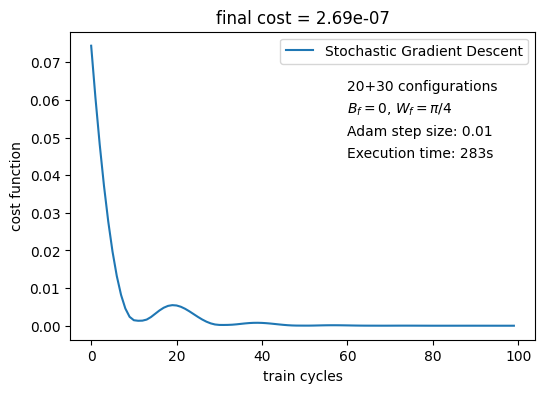

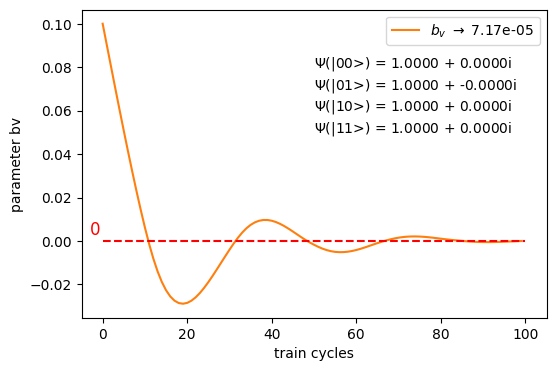

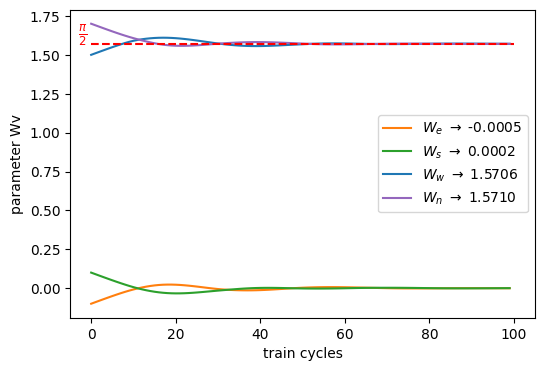

In [ ]:
# Visualize results: Cost
Final = cost.data.item()
fig1 = plt.figure(figsize=(6, 4))
plt.plot(COST, label="Stochastic Gradient Descent")
plt.title("final cost = %.2e" % Final)
plt.text(0.6 * tt, 0.84 * COST[0], "20+30 configurations")
plt.text(0.6 * tt, 0.76 * COST[0], "$B_{f} = 0$, $W_{f} = \pi/4$")
plt.text(0.6 * tt, 0.68 * COST[0], "Adam step size: %.2f" % ss)
plt.text(0.6 * tt, 0.6 * COST[0], "Execution time: %is" % execution_time)
plt.xlabel("train cycles")
plt.ylabel("cost function")
plt.legend()
plt.show()

# Visualize results: BV
fig2 = plt.figure(figsize=(6, 4))
plt.plot(ABV, color='tab:orange', label=r"$b_v$ $\rightarrow$ %.2e" % BV[0].data.item())
plt.plot([0, tt], [0.0, 0.0], 'r--', linewidth=1.5)
plt.text(-0.03 * tt, 0.003, '0', color='r', fontsize=12)
plt.text(0.5 * tt, 0.8 * ABV[0], "$\Psi$(|00>) = %.4f + %.4fi" % (
    ph(BV, WV, BF, WF, SS[0]).data.item().real, ph(BV, WV, BF, WF, SS[0]).data.item().imag))
plt.text(0.5 * tt, 0.7 * ABV[0], "$\Psi$(|01>) = %.4f + %.4fi" % (
    ph(BV, WV, BF, WF, SS[1]).data.item().real, ph(BV, WV, BF, WF, SS[1]).data.item().imag))
plt.text(0.5 * tt, 0.6 * ABV[0], "$\Psi$(|10>) = %.4f + %.4fi" % (
    ph(BV, WV, BF, WF, SS[2]).data.item().real, ph(BV, WV, BF, WF, SS[2]).data.item().imag))
plt.text(0.5 * tt, 0.5 * ABV[0], "$\Psi$(|11>) = %.4f + %.4fi" % (
    ph(BV, WV, BF, WF, SS[3]).data.item().real, ph(BV, WV, BF, WF, SS[3]).data.item().imag))
plt.xlabel("train cycles")
plt.ylabel("parameter bv")
plt.legend()
plt.show()

# Visualize results: WV
fig3 = plt.figure(figsize=(6, 4))
plt.plot(AWV[0], color='tab:orange', label=r"$W_e$ $\rightarrow$ %.4f" % WV[0].data.item())
plt.plot(AWV[1], color='tab:green', label=r"$W_s$ $\rightarrow$ %.4f" % WV[1].data.item())
plt.plot(AWV[2], color='tab:blue', label=r"$W_w$ $\rightarrow$ %.4f" % WV[2].data.item())
plt.plot(AWV[3], color='tab:purple', label=r"$W_n$ $\rightarrow$ %.4f" % WV[3].data.item())
plt.plot([0, tt], [1.5708, 1.5708], 'r--', linewidth=1.5)
plt.text(-0.03 * tt, 1.6, r'$\frac{\pi}{2}$', color='r', fontsize=12)
plt.xlabel("train cycles")
plt.ylabel("parameter Wv")
plt.legend()
plt.show()